In [34]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from scipy.special import erfc

In [2]:
M = 16
k = int(np.log2(M))
n_channel = 2

In [3]:
def non_linear_channel(x):
    return tf.tanh(x)

In [17]:
input_signal = layers.Input(shape=(M,))

x = layers.Dense(2*M, activation='selu')(input_signal) # SELU is better for signals
x = layers.BatchNormalization()(x) # Stabilizes learning
encoded = layers.Dense(n_channel, activation='linear')(x)

encoded = layers.Lambda(lambda x: np.sqrt(n_channel) * (x / tf.sqrt(tf.reduce_mean(tf.square(x)))))(encoded)

distorted = layers.Lambda(non_linear_channel)(encoded)

channel_layer = layers.GaussianNoise(stddev=0.25)
channel_out = channel_layer(distorted)

decoder_dense1 = layers.Dense(2*M, activation='selu')
decoder_bn = layers.BatchNormalization()
decoder_output = layers.Dense(M, activation='softmax')

x = decoder_dense1(channel_out)
x = decoder_bn(x)
output_probs = decoder_output(x)

autoencoder = keras.Model(input_signal, output_probs)
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Reduce LR if accuracy doesn't improve for 5 epochs
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
# Stop training if it stops getting better to save time
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [28]:
print("Training Autoencoder...")
N_train = 1000000
train_labels = np.random.randint(0, M, N_train)
train_onehot = tf.keras.utils.to_categorical(train_labels, M)
autoencoder.fit(
    train_onehot, train_onehot, 
    epochs=200,            # Give it more time (EarlyStopping will cut it short if needed)
    batch_size=1024,       # Large batch size to average out noise
    # callbacks=[lr_scheduler, early_stop],
    verbose=1
)
print("Training Done.")

Training Autoencoder...
Epoch 1/200
977/977 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7180 - loss: 0.7306
Epoch 2/200
977/977 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7185 - loss: 0.7304
Epoch 3/200
977/977 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7181 - loss: 0.7310
Epoch 4/200
977/977 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7186 - loss: 0.7303
Epoch 5/200
977/977 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7177 - loss: 0.7313
Epoch 6/200
977/977 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7181 - loss: 0.7304
Epoch 7/200
977/977 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7181 - loss: 0.7318
Epoch 8/200
977/977 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7174 - loss: 0.7316
Epoch 9/200
977/977 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7188 - loss: 0.7294
Epoch 10/200
977/977 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7174 - loss: 0.7314
Epoch 11/200
977/977 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7180 - loss: 0.7317
Epoch 12/200
977/

In [29]:
encoder_model = keras.Model(input_signal, encoded)

decoder_input = layers.Input(shape=(n_channel,))
x = decoder_dense1(decoder_input)
x = decoder_bn(x)
x = decoder_output(x)
decoder_model = keras.Model(decoder_input, x)

In [30]:
# --- Helper: Generate Standard 16-QAM Constellation ---
def get_standard_16qam():
    # 16-QAM is a 4x4 grid: -3, -1, +1, +3
    points = []
    for i in [-3, -1, 1, 3]:
        for q in [-3, -1, 1, 3]:
            points.append([i, q])
    points = np.array(points)
    # Normalize Average Power to 1
    # Avg Power of unnormalized grid is 10.
    points = points / np.sqrt(10) 
    return points

standard_constellation = get_standard_16qam()

In [31]:
snr_db_range = np.arange(0, 15, 1)
ber_ai = []
ber_std = []

def get_noise_std(snr_db):
    snr_linear = 10**(snr_db / 10.0)
    return np.sqrt(1.0 / snr_linear)

print("Running Comparison Simulation...")

for snr in snr_db_range:
    noise_std = get_noise_std(snr)
    N_test = 100000 
    test_labels = np.random.randint(0, M, N_test)
    test_onehot = tf.keras.utils.to_categorical(test_labels, M)
    
    tx_ai = encoder_model.predict(test_onehot, verbose=0)
    tx_ai_dist = np.tanh(tx_ai)
    rx_ai = tx_ai_dist + np.random.normal(0, noise_std, size=tx_ai.shape)
    
    pred_probs = decoder_model.predict(rx_ai, verbose=0)
    pred_ai = np.argmax(pred_probs, axis=1)
    ber_ai.append(np.sum(pred_ai != test_labels) / N_test)
    
    tx_std = standard_constellation[test_labels] # Simple lookup

    tx_std_dist = np.tanh(tx_std)
    rx_std = tx_std_dist + np.random.normal(0, noise_std, size=tx_std.shape)
    
    distances = np.sum((rx_std[:, np.newaxis, :] - standard_constellation[np.newaxis, :, :])**2, axis=2)
    pred_std = np.argmin(distances, axis=1)
            
    ber_std.append(np.sum(pred_std != test_labels) / N_test)
    
    print(f"SNR {snr}dB | AI SER: {ber_ai[-1]:.5f} | Std SER: {ber_std[-1]:.5f}")

print("Done...")

Running Comparison Simulation...
SNR 0dB | AI SER: 0.80863 | Std SER: 0.84333
SNR 1dB | AI SER: 0.78654 | Std SER: 0.82759
SNR 2dB | AI SER: 0.76470 | Std SER: 0.81115
SNR 3dB | AI SER: 0.73719 | Std SER: 0.79316
SNR 4dB | AI SER: 0.70861 | Std SER: 0.77252
SNR 5dB | AI SER: 0.67260 | Std SER: 0.74910
SNR 6dB | AI SER: 0.63206 | Std SER: 0.72229
SNR 7dB | AI SER: 0.58414 | Std SER: 0.68882
SNR 8dB | AI SER: 0.53087 | Std SER: 0.65260
SNR 9dB | AI SER: 0.47461 | Std SER: 0.61242
SNR 10dB | AI SER: 0.41567 | Std SER: 0.56359
SNR 11dB | AI SER: 0.34766 | Std SER: 0.52149
SNR 12dB | AI SER: 0.28151 | Std SER: 0.46935
SNR 13dB | AI SER: 0.21780 | Std SER: 0.41780
SNR 14dB | AI SER: 0.15778 | Std SER: 0.36906
Done...


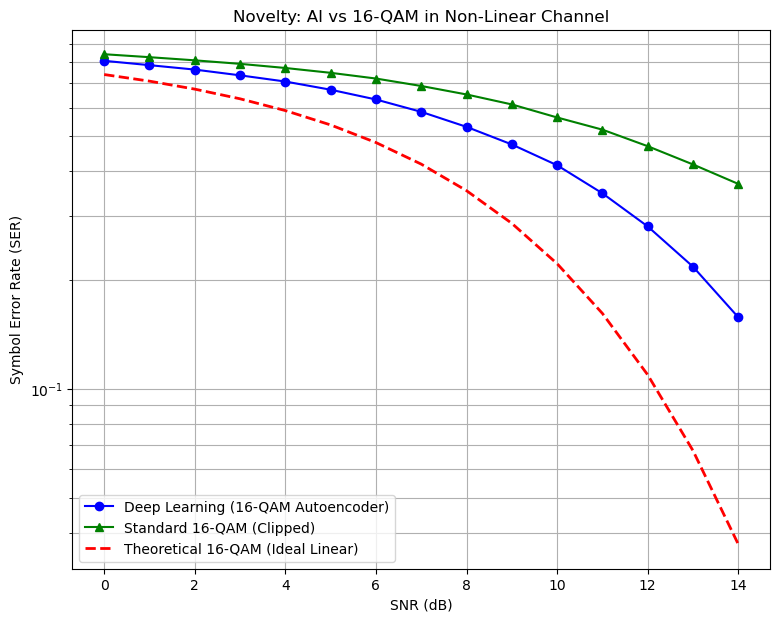

In [32]:
plt.figure(figsize=(9,7))
plt.semilogy(snr_db_range, ber_ai, 'bo-', label='Deep Learning (16-QAM Autoencoder)')
plt.semilogy(snr_db_range, ber_std, 'g^-', label='Standard 16-QAM (Clipped)')

def theory_mqam_ser(snr_db, M):
    snr_linear = 10**(snr_db/10.0)
    # P_sqrt_M term for rectangular QAM
    # Argument for Q-function: sqrt(3*SNR / (M-1))
    # erfc is 2*Q(x*sqrt(2)) -> Q(x) = 0.5*erfc(x/sqrt(2))
    k = np.sqrt(3 * snr_linear / (M - 1))
    pm = (1 - 1/np.sqrt(M)) * erfc(k / np.sqrt(2))
    ser = 1 - (1 - pm)**2
    return ser

theory_curve = [theory_mqam_ser(x, M) for x in snr_db_range]
plt.semilogy(snr_db_range, theory_curve, 'r--', linewidth=2, label='Theoretical 16-QAM (Ideal Linear)')

plt.title('Novelty: AI vs 16-QAM in Non-Linear Channel')
plt.xlabel('SNR (dB)')
plt.ylabel('Symbol Error Rate (SER)')
plt.legend()
plt.grid(True, which="both")
plt.show()

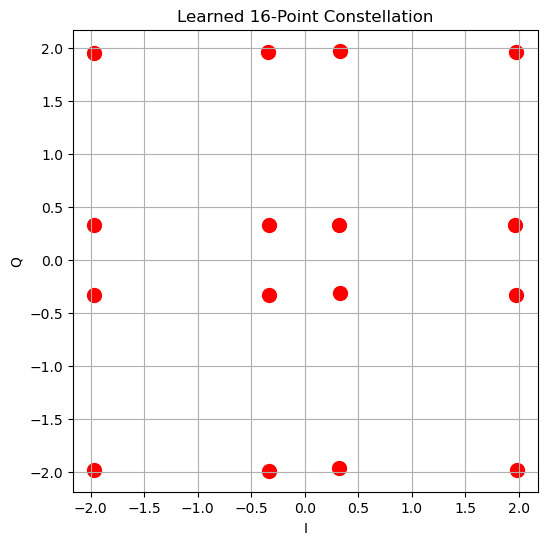

In [33]:
scatter_points = encoder_model.predict(np.eye(M), verbose=0)
plt.figure(figsize=(6,6))
plt.scatter(scatter_points[:,0], scatter_points[:,1], c='red', s=100)
plt.title("Learned 16-Point Constellation")
plt.grid(True)
plt.xlabel("I"); plt.ylabel("Q")
plt.show()